<a href="https://colab.research.google.com/github/benwulmer/CDA/blob/main/1_TrendsExtremes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ERA5 reanalysis

## Introduction

This notebook provides an introduction to download and working with the ERA5 *reanalysis* dataset. A reanalysis is created by assimilating historical observations into a global climate model to produce a physically consistent estimate of the past atmospheric state. The ERA5 dataset is extremely useful for various problems in climate science. It was also used to train AI forecast models like Graphcast.

### What is ERA5?

ERA5 is the fifth generation ECMWF (European Centre for Medium-Range Weather Forecasts) atmospheric reanalysis of the global climate. It provides:

- Hourly estimates of atmospheric, land, and oceanic climate variables
- Global coverage at 0.25° × 0.25° resolution (~31 km)
- Data from 1940 to present (with about 5-day latency)
- Consistent, gap-free estimate of recent climate state

### ERA5 Data Temporal Resolutions

ERA5 data is available at various temporal resolutions. Here, we will work with two temporal resolutions. `reanalysis-era5-single-levels` contains data saved at hourly temporal resolution, and `reanalysis-era5-single-levels-monthly-means` contains data saved at monthly resolution. It is of course possible to calculate monthly averages from hourly resolution data, but this would be much slower and would require more memory and/or disk space.

## Setup and Installation

Before we start we need to install some required packages. The cell below will install the required packages.


In [1]:
# Install required packages
%pip install -q earthkit-data cdsapi xarray netcdf4 matplotlib cartopy numpy regionmask xeofs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 932.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.7/389.7 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.4/20.4 MB

Now, load the packages

In [2]:
# Import libraries
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthkit.data
import regionmask

print("All libraries imported successfully!")

All libraries imported successfully!


## CDS API Configuration

To download ERA5 data, you need a free account on the **Climate Data Store (CDS)**.

### How to get your API key:

1. Go to https://cds.climate.copernicus.eu/
2. Create a free account or log in
3. Click on your name in the top right → select "Profile"
4. Find your API key and click the copy icon
5. Paste it in the code cell below

**Important:** You must also accept the dataset terms by visiting:
- https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means
- https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels


In [3]:
# ==========================================
# ENTER YOUR CDS API KEY HERE
# ==========================================
CDS_URL = 'https://cds.climate.copernicus.eu/api'
CDS_API_KEY = "1b97f6c6-26b8-45a5-8e27-5e8360276f64"  # Replace with your actual API key (format: xxxxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxx)

# Set as environment variables for earthkit
os.environ['CDSAPI_URL'] = CDS_URL
os.environ['CDSAPI_KEY'] = CDS_API_KEY


---

## Introduction to xarray

xarray is a Python library that makes working with multi-dimensional labeled arrays intuitive and efficient. It's particularly well-suited for climate data. See https://docs.xarray.dev/en/stable/index.html for more detailed information.

### File formats

Xarray allows us to read data stored in a wide range of file formats, including NetCDF, HDF5, zarr, GRIB, and OPeNDAP which are commonly used for climate data.

### Data labelling

Unlike numpy arrays, xarray allows us to add labels to our dataset which make it much easier to work with.

- **Labeled dimensions**: Instead of remembering what the first and second array dimension correspond to (as in a numpy array), xarray allows us to name the dimensions of an array (e.g. time, latitude, height, etc.)

- **Coordinates**: Data can be associated with coordinate values (e.g., actual dates, lat/lon values), not just integer indices like in numpy arrays.

- **Metadata preservation**: We can add metadata to keep track of units, add descriptions, and other assign other attributes to the data

### Data Chunking

Climate datasets can be enormous (petabytes!). **Chunking** divides data into smaller pieces that can be loaded on demand. This makes it much faster to read and operate on data in cases where we don't need all of the data for our particular analysis. Chunks can be arranged in space or time for doing spatial analysis (e.g. mapping) or in time for timeseries analysis.

### Data structures

xarray has two main data structures:

1. **Dataset**: A collection of multiple variables (DataArrays) that share dimensions
   - Like a Python dictionary of DataArrays
   - Example: A file containing temperature, pressure, and precipitation as functions of latitude, longitude, and time.
   
2. **DataArray**: A single multi-dimensional variable with dimensions and coordinates
   - Analogous to a NumPy array, but with labels
   - Example: Ground temperature as a function of latitude, longitude and time.

`dataset['temperature']` or `dataset.temperature` where `dataset` is the name of a Dataset returns a DataArray


### Built-in Xarray operations

xarray provides a rich set of built-in operations for working with labeled multi-dimensional arrays. Here are some particularly useful operations for analyzing climate data. The operations can be applied to DataArrays using the name of the DataArray followed by . and then the name of the operation.

#### **Selection and Indexing**
- **`.sel()`**: Select by coordinate label (e.g., `data.sel(time='2024-01-01', lat=51.5)` where `data` is the name of a DataArray selects data at the specified date and latitude)
- **`.sel(method='nearest')`**: Find nearest grid point to a coordinate value
- **`.squeeze()`**: Remove dimensions of length 1 (singleton dimensions)
- **`.values`**: Access the underlying NumPy array
- **`.dims`**: Get dimension names
- **`.coords`**: Access coordinate arrays

#### **Aggregation Operations**
- **`.mean()`**: Calculate mean along dimension(s)
- **`.sum()`**: Calculate sum along dimension(s)
- **`.std()`**: Calculate standard deviation
- **`.min()`**, **`.max()`**: Find minimum/maximum values
- **`.argmax()`**, **`.argmin()`**: Find indices of maximum/minimum values

#### **Temporal Operations**
- **`.resample()`**: Change temporal resolution (e.g., `data.resample(time='1D').mean()`)
- **`.rolling()`**: Rolling window operations (e.g., `data.rolling(time=12).mean()` takes the rolling annual average when applied to monthly data)
- **`.groupby()`**: Group by dimension or coordinate for subsequent operations (e.g., `data.groupby('time.month').mean()` averages data with the same month (e.g. January).)

#### **Mathematical Operations**
- **`.polyfit()`**: Fit polynomial trends (e.g., `data.polyfit(dim='time', deg=1)` fits a line to the data)
- **`.transpose()`**: Changes the order of the dimensions (e.g., `data.transpose('time', 'lat', 'lon')` changes the order of the DataArray so that time comes first, followed by latitude and then longitude). This is sometimes needed for operations that expect the spatiotemporal data in a certain order.

#### **Data Manipulation**
- **`.plot()`**: Built-in plotting with automatic coordinate handling
- **Arithmetic operations**: Xarray can do direct math operations (e.g., `data - 273.15`, `data1 + data2`)

#### **Other Common Operations** (useful for advanced analysis)
- **`.where()`**: Conditional selection (e.g., `data.where(data > 0)`)
- **`.interp()`**: Interpolate to new coordinates
- **`.assign()`**: Add new variables to Dataset (e.g., `ds.assign(temp_c=data - 273.15)`)
- **`.rename()`**: Rename dimensions or variables
- **`.drop()`**: Remove (drop) dimensions or variables
- **`.stack()`** / **`.unstack()`**: Reshape dimensions (stack creates MultiIndex, unstack expands it)
- **`.load()`** / **`.compute()`**: Load/compute lazy (chunked) data into memory
- **`.to_netcdf()`** / **`.to_zarr()`**: Save to netcdf or zarr files
- **`.copy()`**: Create a copy of the data


---

### Example 1: Surface temperature at a specified location

In this example, we will:
1. Download monthly averaged 2m temperature data for a specified location
2. Calculate a 12-month rolling average using xarray
3. Fit a linear trend over the full timeseries to quantify warming
4. Plot the monthly timeseries and the linear warming trend


In [4]:
# Configuration for Example 1
# approximate location of Cambridge
LAT = 37.8
LON = -122.42
START_YEAR = 1940
END_YEAR = 2024


First, we use the `earthkit.data` library to download ERA5 from the Climate Data Store. The monthly means dataset provides pre-computed monthly averages, which is much more efficient than downloading hourly data.


In [5]:

dataset = "reanalysis-era5-single-levels-monthly-means"

# Create list of years and months
years = [str(y) for y in range(START_YEAR, END_YEAR + 1)]
months = [f"{m:02d}" for m in range(1, 13)]

request = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": ["total_precipitation"],
    "year": years,
    "month": months,
    "time": "00:00",
    "area": [LAT, LON, LAT, LON],  # North, West, South, East (single point)
    "data_format": "netcdf",
    "download_format": "unarchived"
}

print(f"Downloading monthly data...")
print("(This may take 1-2 minutes)")

monthly_data = earthkit.data.from_source("cds", dataset, request).to_xarray()

print('Done downloading data')

(This may take 1-2 minutes)


2026-02-09 16:30:13,931 INFO Request ID is 973f2f61-9a90-4a53-9a0d-69f9d6fb72c6
INFO:ecmwf.datastores.legacy_client:Request ID is 973f2f61-9a90-4a53-9a0d-69f9d6fb72c6
2026-02-09 16:30:14,103 INFO status has been updated to accepted
INFO:ecmwf.datastores.legacy_client:status has been updated to accepted
2026-02-09 16:30:29,746 INFO status has been updated to successful
INFO:ecmwf.datastores.legacy_client:status has been updated to successful


ad0439a5cf1306f218e6264de63fa99b.nc:   0%|          | 0.00/117k [00:00<?, ?B/s]

Done downloading data


In [6]:
monthly_dataOne = xr.open_dataset("monthly_data_pt1.nc")
monthly_dataTwo = xr.open_dataset("monthly_data_pt2.nc")
monthly_dataHumidity = xr.open_dataset("monthly_data_humidity.nc")
print(monthly_dataOne, monthly_dataTwo, monthly_dataHumidity)

<xarray.Dataset> Size: 73kB
Dimensions:     (valid_time: 2040, latitude: 1, longitude: 1)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 16kB 1940-01-01 ... 2024-12-01T06...
  * latitude    (latitude) float64 8B 37.8
  * longitude   (longitude) float64 8B -122.4
    number      int64 8B ...
    expver      (valid_time) <U4 33kB ...
Data variables:
    tp          (valid_time, latitude, longitude) float32 8kB ...
    u10         (valid_time, latitude, longitude) float32 8kB ...
    v10         (valid_time, latitude, longitude) float32 8kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-02-06T15:37 GRIB to CDM+CF via cfgrib-0.9.1... <xarray.Dataset> Size: 65kB
Dimensions:     (valid_time: 2040, latitude: 1, longitude: 1

In [7]:
import math
a1 = 611.21
a3 = 17.502
a4 = 32.19

R_dry = 287.053
R_vap = 461.5
T0 =  273.16

#T_0 - triple point temperature?
def esat(T):
  return a1 * math.exp(a3 * (T-T0)/(T-a4))



#pressure p and Temp T, r_dry and r_vap are gas constants for dry air an water vapor
def humidity(p, T):
  return R_dry / R_vap * esat(T) / ((p-(1-R_dry/R_vap)))

In [8]:
humidities = []
for i in range(len(monthly_dataHumidity.sp)):
  humidities.append(humidity(monthly_dataHumidity.sp.values[i], monthly_dataHumidity.d2m.values[i]))
print(humidities)



[array([[0.00594533]], dtype=float32), array([[0.0061514]], dtype=float32), array([[0.00637279]], dtype=float32), array([[0.00685999]], dtype=float32), array([[0.00757647]], dtype=float32), array([[0.00811092]], dtype=float32), array([[0.00842351]], dtype=float32), array([[0.00866507]], dtype=float32), array([[0.00914066]], dtype=float32), array([[0.0081109]], dtype=float32), array([[0.00596378]], dtype=float32), array([[0.00598225]], dtype=float32), array([[0.00605195]], dtype=float32), array([[0.00675562]], dtype=float32), array([[0.00663597]], dtype=float32), array([[0.00657639]], dtype=float32), array([[0.00749515]], dtype=float32), array([[0.00798256]], dtype=float32), array([[0.00864451]], dtype=float32), array([[0.00872614]], dtype=float32), array([[0.00788381]], dtype=float32), array([[0.0069975]], dtype=float32), array([[0.00658336]], dtype=float32), array([[0.00654018]], dtype=float32), array([[0.0056991]], dtype=float32), array([[0.00549024]], dtype=float32), array([[0.00585

/tmp/ipython-input-2557427804.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return a1 * math.exp(a3 * (T-T0)/(T-a4))


In [9]:
print(monthly_dataHumidity.sp['valid_time'].values)

['1940-01-01T00:00:00.000000000' '1940-02-01T00:00:00.000000000'
 '1940-03-01T00:00:00.000000000' ... '2024-10-01T00:00:00.000000000'
 '2024-11-01T00:00:00.000000000' '2024-12-01T00:00:00.000000000']


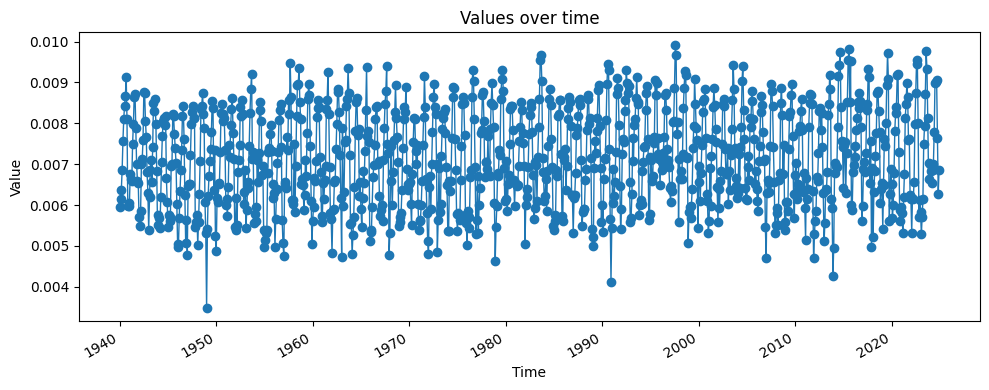

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

times_dt = np.squeeze(monthly_dataHumidity.sp['valid_time'].values)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(times_dt, np.squeeze(humidities), marker="o", linewidth=1)

ax.set_title("Values over time")
ax.set_xlabel("Time")
ax.set_ylabel("Value")

# Nice date formatting (optional but helpful)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

fig.autofmt_xdate()
plt.tight_layout()
plt.show()


Now that we have downloaded the data, we can look at the dataset using the print command. Notice how xarray provides the dimension names (valid_time, latitude, longitude), coordinates, data variables, and attributes to describe the data.

In [11]:
# Examine the xarray Dataset structure
print("Dataset structure:")
print(monthly_data)

# relabel the time dimension to 'time' for convenience
monthly_data = monthly_data.rename({'valid_time': 'time'})


Dataset structure:
<xarray.Dataset> Size: 29kB
Dimensions:     (valid_time: 1020, latitude: 1, longitude: 1)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01T06:00:00 ... 2024-...
  * latitude    (latitude) float64 8B 37.8
  * longitude   (longitude) float64 8B -122.4
    number      int64 8B ...
    expver      (valid_time) <U4 16kB dask.array<chunksize=(1020,), meta=np.ndarray>
Data variables:
    tp          (valid_time, latitude, longitude) float32 4kB dask.array<chunksize=(1020, 1, 1), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-02-06T15:28 GRIB to CDM+CF via cfgrib-0.9.1...


As a simple example for manipulating the data, let's convert the 2m air temperature from Kelvin to Celsius and find the minimum, maximum, and average (mean) temperature.

In [12]:
# Extract 2m temperature and convert to Celsius
precip_raw = monthly_data.tp.squeeze()  # Remove singleton lat/lon dimensions

# Get time values
times = precip_raw['time'].values # .values is used to access the underlying numpy array
precip = precip_raw.values

print(f"Temperature range: {precip.min():.4f}°C to {precip.max():.4f}°C")
print(f"Mean temperature: {precip.mean():.4f}°C")


Temperature range: 0.0000°C to 0.0121°C
Mean temperature: 0.0015°C


We can use **xarray's rolling** method to perform operations on a rolling group of data. Here, we will do this to calculate a rolling annual average on the monthly data.

In [13]:
# Calculate 12-month rolling average (centered) using xarray
# xarray's rolling() works directly on DataArrays with labeled dimensions
rolling_avg = precip_raw.rolling({'time': 12}, center=True).mean()

Now, let's use the polyfit function from numpy to fit a linear trend to the timeseries.

In [15]:
print(monthly_dataOne.tp.squeeze())

<xarray.DataArray 'tp' (valid_time: 2040)> Size: 8kB
[2040 values with dtype=float32]
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 16kB 1940-01-01 ... 2024-12-01T06...
    latitude    float64 8B 37.8
    longitude   float64 8B -122.4
    number      int64 8B ...
    expver      (valid_time) <U4 33kB ...
Attributes: (12/32)
    GRIB_paramId:                             228
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      1
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            avgad
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Total precipitation
    units:                                    m
    standard_name:                            unknown
    GRIB_surface:                             0.

In [16]:
# Fit linear trend using numpy polyfit
# Convert dates to numeric values (months since start)
x = np.arange(len(precip))
slope, intercept = np.polyfit(x, precip, 1)
trend_line = slope * x + intercept

# Calculate warming rate per decade
# slope is per month, multiply by 12*10 for per decade
warming_rate = slope * 120

print(f"Linear trend: {warming_rate:+.3f}°C per decade")
print(f"Total warming ({START_YEAR}-{END_YEAR}): {warming_rate * (END_YEAR - START_YEAR) / 10:.10f}°C")


Linear trend: +0.000°C per decade
Total warming (1940-2024): 0.0000595240°C


In [17]:
def plot_data(data_raw, variable, units):
  data_raw = data_raw.rename({'valid_time': 'time'})
  dim = data_raw.dims[0]
  data_raw = data_raw.dropna(dim=dim).squeeze()
  times = data_raw['time'].values
  data = data_raw.values
  x = np.arange(len(data))
  slope, intercept = np.polyfit(x, data, 1)
  trend_line = slope * x + intercept

  rolling_avg = data_raw.rolling({'time': 12}, center=True).mean()
  # Set the default font and figure size (this will apply to later plots too)
  plt.rcParams['figure.figsize'] = [12, 6]
  plt.rcParams['font.size'] = 18
  # Create figure
  fig, ax = plt.subplots(figsize=(14, 7))

  # Plot monthly data
  ax.plot(times, data, color='#7FB3D5', linewidth=0.8, alpha=0.7,
          label='Monthly mean')

  # Plot 12-month rolling average
  ax.plot(times, rolling_avg.values, color='#2E86AB', linewidth=2.5,
          label='12-month rolling average')

  # Plot linear trend
  ax.plot(times, trend_line, color='#E94F37', linewidth=2, linestyle='--',
          label=f'Linear trend ({slope * 120:+.2f} {units}/decade)')

  # Formatting
  ax.set_xlabel('Year')
  ax.set_ylabel(f'{variable} ({units})')
  ax.set_title(f'ERA5 {variable} ({LAT}°N, {LON}°E)\n', fontsize=18, fontweight='bold')

  ax.grid(True, alpha=0.3)

  # Add reference line at 0°C
  ax.axhline(y=0, color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
  plt.legend()
  plt.tight_layout()
  plt.savefig(f'{variable}_graph.png', dpi=150, bbox_inches='tight')
  plt.show()

  print(f"\nPlot saved as '{variable}_graph.png'")

    # ---- Summary stats ----
  # Monthly stats
  monthly_mean = float(data_raw.mean())
  monthly_min  = float(data_raw.min())
  monthly_max  = float(data_raw.max())

  # Rolling stats (drop NaNs created at the ends)
  roll_valid = rolling_avg.dropna(dim="time")
  roll_mean = float(roll_valid.mean()) if roll_valid.size else float("nan")
  roll_min  = float(roll_valid.min())  if roll_valid.size else float("nan")
  roll_max  = float(roll_valid.max())  if roll_valid.size else float("nan")

  # Trend summary
  per_decade = slope * 120  # monthly cadence assumption
  # Optional: intercept is at x=0 (first point in your filtered series)
  print("\n--- Summary ---")
  print(f"Monthly: mean={monthly_mean:.4g} {units}, min={monthly_min:.4g}, max={monthly_max:.4g}")
  print(f"12-mo rolling: mean={roll_mean:.4g} {units}, min={roll_min:.4g}, max={roll_max:.4g}")
  print(f"Linear fit: y = {slope:.4g}*x + {intercept:.4g}  (≈ {per_decade:+.4g} {units}/decade)")
  print(f"Count: n_monthly={data_raw.size}, n_roll12={roll_valid.size}")
  print(f"Time span: {str(times[0])} → {str(times[-1])}")



In [18]:
import numpy as np

eps = R_dry / R_vap  # ~0.622

def esat_np(Tk):
    return a1 * np.exp(a3 * (Tk - T0) / (Tk - a4))  # Pa

e = esat_np(monthly_dataHumidity.d2m)  # vapour pressure from dewpoint (Pa)

q2m = 1000* eps * e / (monthly_dataHumidity.sp - (1 - eps) * e)  # kg/kg
q2m = q2m.rename("q2m")
q2m.attrs["long_name"] = "2m specific humidity (from dewpoint + surface pressure)"
q2m.attrs["units"] = "kg kg-1"


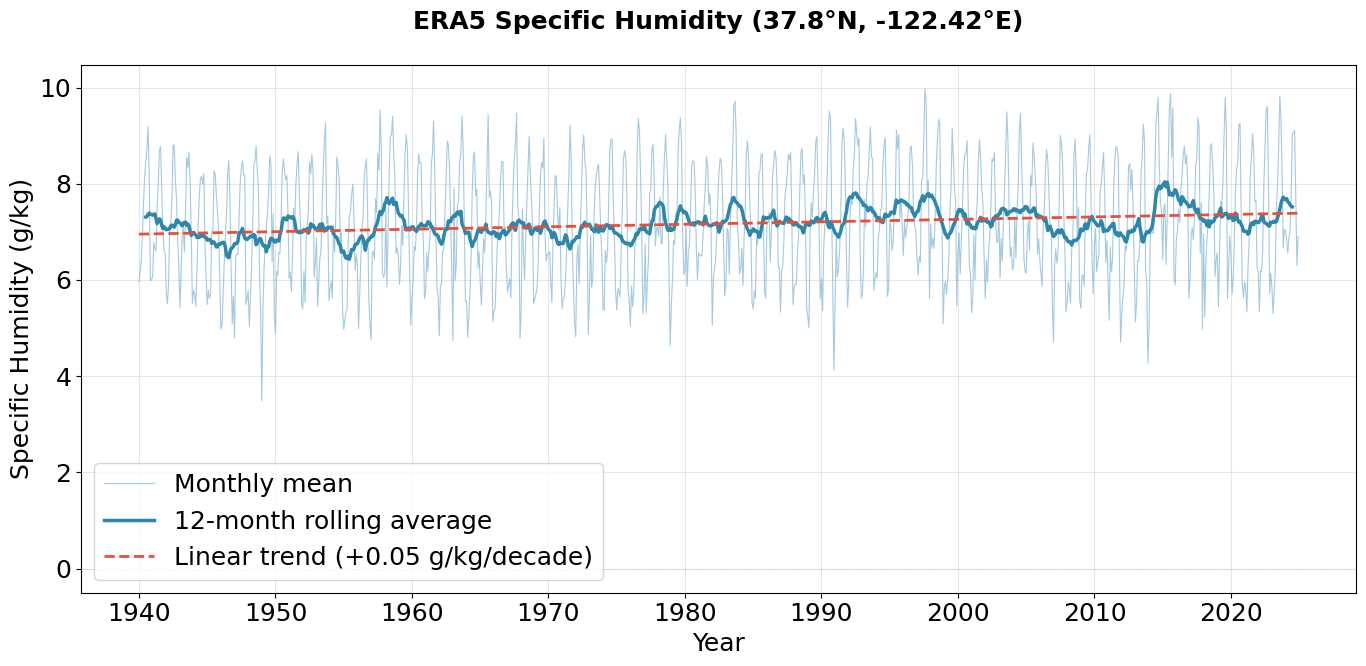


Plot saved as 'Specific Humidity_graph.png'

--- Summary ---
Monthly: mean=7.17 g/kg, min=3.491, max=9.967
12-mo rolling: mean=7.168 g/kg, min=6.431, max=8.04
Linear fit: y = 0.0004258*x + 6.953  (≈ +0.0511 g/kg/decade)
Count: n_monthly=1020, n_roll12=1009
Time span: 1940-01-01T00:00:00.000000000 → 2024-12-01T00:00:00.000000000


In [19]:
# variable, units
# q2m humidity
# monthly_dataOne -> t2m temp 2m
#
plot_data(q2m, "Specific Humidity", "g/kg")

### Warming stripes

Just for fun, let's plot the `warming stripes' at our location. ("Warming stripes" are a minimalist visualization created by climatologist Ed Hawkins that shows temperature changes over time using only color.)


In [ ]:
# Calculate annual mean temperatures from monthly data
# First, add a 'year' coordinate to group by
temp_with_year = precip_raw.assign_coords(year=('time', precip_raw['time'].dt.year.data))

# Calculate annual average for each year
annual_temps = temp_with_year.groupby('year').mean()

# Calculate anomalies (departure from long-term mean)
mean_temp = annual_temps.mean().values
anomalies = annual_temps - mean_temp

# Create climate stripes plot
fig, ax = plt.subplots(figsize=(14, 3))

# Create a colormap (blue for cold, red for warm)
cmap = plt.cm.RdBu_r  # Reversed Red-Blue colormap

# Determine color scale limits for symmetry
vmax = max(abs(anomalies.min().values), abs(anomalies.max().values))
vmin = -vmax

# Plot each year as a vertical bar
years = anomalies.year.values
for i, year in enumerate(years):
    ax.bar(year, 1, width=1.0, color=cmap((anomalies.sel(year=year).values - vmin) / (vmax - vmin)),
           edgecolor='none')

# Remove all axes, labels, and ticks for the iconic climate stripes look
ax.set_xlim(years[0] - 0.5, years[-1] + 0.5)
ax.set_ylim(0, 1)
ax.axis('off')

# Add title
ax.set_title(f'Warming Stripes for {LAT}°N, {LON}°E',
             fontweight='bold', pad=10)

plt.tight_layout(pad=0.5)
plt.savefig('warming_stripes.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved as 'warming_stripes.png'")


---

### Example 2: Global warming patterns

Next, let's calculate the spatial patterns associated with the change in the 2m temperature. To do this, we will calculate the difference between the 2m temperature averaged over the first and last decade in the ERA5 datset. This will allow us to illustrate xarray's *groupby* operation.

In [ ]:
# Define the decades to compare
FIRST_DECADE = (1940, 1949)
LAST_DECADE = (2015, 2024)


In [ ]:
# Download global 2m temperature data for both decades
dataset = "reanalysis-era5-single-levels-monthly-means"

# Create list of years for both decades
years_first = [str(y) for y in range(FIRST_DECADE[0], FIRST_DECADE[1] + 1)]
years_last = [str(y) for y in range(LAST_DECADE[0], LAST_DECADE[1] + 1)]
all_years = years_first + years_last

months = [f"{m:02d}" for m in range(1, 13)]

request = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": ["2m_temperature"],
    "year": all_years,
    "month": months,
    "time": "00:00",
    "data_format": "netcdf",
    "download_format": "unarchived"
}

print(f"Downloading global 2m temperature data...")
print(f"  Years: {FIRST_DECADE[0]}-{FIRST_DECADE[1]} and {LAST_DECADE[0]}-{LAST_DECADE[1]}")
print("  Coverage: Global")
print("  (This may take several minutes for global data)")

global_temp_data = earthkit.data.from_source("cds", dataset, request).to_xarray()

print("Done downloading data")


Next, we will use xarray's groupby operation to average the data over each decade. By doing the groupby operation first to group by decade and then nesting a mean over the time dimension, we can obtain the decadal average.

In [ ]:
# Extract 2m temperature
temp_global = global_temp_data.t2m

# relabel the time dimension to 'time' for convenience
temp_global = temp_global.rename({'valid_time': 'time'})

# Add a 'decade' coordinate to group data by decade
# This demonstrates xarray's powerful groupby operation
years = temp_global['time'].dt.year
decade_labels = xr.where(
    (years >= FIRST_DECADE[0]) & (years <= FIRST_DECADE[1]),
    'first_decade',
    'last_decade'
)
temp_with_decade = temp_global.assign_coords(decade=('time', decade_labels.data))

# Use groupby to calculate the average temperature for each decade
# This is a key xarray operation for aggregating data
decadal_avg = temp_with_decade.groupby('decade').mean(dim='time')

# Extract the two decades
first_decade_temp = decadal_avg.sel(decade='first_decade')
last_decade_temp = decadal_avg.sel(decade='last_decade')

# Calculate the warming (temperature difference)
warming = last_decade_temp - first_decade_temp



Finally, let's plot a map of the net warming. This shows that the warming trend is not spatially uniform. In particular notice the amplification in the warming signal in the Arctic region. There has also been more warming in dry regions (with less buffering from the heat capacity of water).

In [ ]:
# Create figure with Robinson projection
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# Common plotting parameters
vmin, vmax = -5, 5  # Temperature change range in °C
cmap = 'RdBu_r'  # Blue for cooling, white at zero, red for warming

# Create a diverging norm centered at zero (so white is at 0°C change)
import matplotlib.colors as mcolors
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot the warming data
im = ax.pcolormesh(
    warming.longitude,
    warming.latitude,
    warming.values,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    shading='auto'
)

# Add coastlines and features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=0.3, linestyle=':', edgecolor='gray')

# Add gridlines
gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray',
                  alpha=0.3, linestyle='--')

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8, extend='both')
cbar.set_label(f'Temperature Change (°C): {FIRST_DECADE[0]}s to {LAST_DECADE[0]}s')

# Title
ax.set_title(f'Decadal mean temperature change: ({LAST_DECADE[0]}-{LAST_DECADE[1]}) - ({FIRST_DECADE[0]}-{FIRST_DECADE[1]})',
             fontweight='bold', pad=15)

plt.tight_layout()
plt.savefig('global_warming_map.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Plot saved as 'global_warming_map.png'")


---

### Example 3: Extreme precipitation

In this example, we will find the wettest month in the UK and explore the weather patterns associated with that month. To do that, we will use the regionmask and geopandas packages to average the precipitation over all lat/lon values that are within the UK. You can use these packages to find analyze the climate of other countries.

In [ ]:
# Define the time period
START_YEAR = 1940
END_YEAR = 2024

# Use regionmask to get country boundaries from Natural Earth data
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110

# Find the UK index
UK_INDEX = 143  # United Kingdom in Natural Earth dataset

# Define a bounding box for downloading (we'll mask to UK after)
# This needs to be slightly larger than the UK to ensure we capture all coastal areas
UK_BBOX = [62, -12, 48, 4]  # [North, West, South, East] - covers UK with margin

# North Atlantic region for sea level pressure analysis [North, West, South, East]
NORTH_ATLANTIC_REGION = [70, -80, 10, 20]

In [ ]:
# Download ERA5 monthly total precipitation for the UK bounding box
dataset = "reanalysis-era5-single-levels-monthly-means"

years = [str(y) for y in range(START_YEAR, END_YEAR + 1)]
months = [f"{m:02d}" for m in range(1, 13)]

request = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": ["total_precipitation"],
    "year": years,
    "month": months,
    "time": "00:00",
    "area": UK_BBOX,  # Bounding box covering UK bounding box
    "data_format": "netcdf",
    "download_format": "unarchived"
}

print(f"Downloading monthly precipitation data for UK bounding box...")
print(f"  Years: {START_YEAR}-{END_YEAR}")
print(f"  Bounding box: {UK_BBOX}")
print("  (This may take 1-2 minutes)")

precip_data = earthkit.data.from_source("cds", dataset, request).to_xarray()

print(f"Done downloading data")


In [ ]:
# Now, find the wettest month in the historical record

# Extract precipitation
precip = precip_data.tp

# relabel the time dimension to 'time' for convenience
precip = precip.rename({'valid_time': 'time'})

# Convert from meters to millimeters (ERA5 gives precipitation in meters)
precip_mm = precip * 1000

# Create a mask using regionmask to identify UK grid points
# This uses actual country boundaries from Natural Earth data
uk_mask = countries.mask(precip_mm.longitude, precip_mm.latitude)

# Apply the mask: set non-UK points to NaN
precip_uk_only = precip_mm.where(uk_mask == UK_INDEX)

# Average over the UK region (spatial average, ignoring NaN)
# This gives us the UK-averaged precipitation for each month
precip_uk_avg = precip_uk_only.mean(dim=['latitude', 'longitude'])

# Find the wettest month
max_precip_idx = int(precip_uk_avg.argmax())
wettest_date = precip_uk_avg['time'].values[max_precip_idx]
max_precip_value = float(precip_uk_avg.values[max_precip_idx])

# Convert numpy datetime64 to Python datetime
wettest_date_dt = wettest_date.astype('M8[ms]').astype('O')
wettest_year = wettest_date_dt.year
wettest_month = wettest_date_dt.month

print("\nWETTEST MONTH on record for UK:")
print(f"   Date: {wettest_date_dt.strftime('%B %Y')}")
print(f"   UK-averaged precipitation: {max_precip_value:.1f} mm")


Let's try to gain some insight into what was happening in the atmosphere that led to these extreme conditions. To do this, we will download the sea level pressure for the February across the full ERA5 dataset.  That will let us compare with 2020 to see what patterns in sea level pressure might have led to this particularly wet month. Note that we download data for a broader North Atlantic region to see the large-scale atmospheric circulation pattern associated with this month.

In [ ]:
# Now, download mean sea level pressure data for the wettest month on record
dataset = "reanalysis-era5-single-levels-monthly-means"

years = [str(y) for y in range(START_YEAR, END_YEAR + 1)]
month_str = f"{wettest_month:02d}"

request = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": ["mean_sea_level_pressure"],
    "year": years,
    "month": [month_str],
    "time": "00:00",
    "area": NORTH_ATLANTIC_REGION,
    "data_format": "netcdf",
    "download_format": "unarchived"
}

print(f"Downloading mean sea level pressure data for month {wettest_month} ({wettest_date_dt.strftime('%B')})")
print(f"  Years: {START_YEAR}-{END_YEAR}")
print(f"  Region: {NORTH_ATLANTIC_REGION}")
print("  (This may take several minutes for a large region)")

mslp_data = earthkit.data.from_source("cds", dataset, request).to_xarray()

# relabel the time dimension to 'time' for convenience
mslp_data = mslp_data.rename({'valid_time': 'time'})


Now, calculate the montly average (climatology) of the sea level pressure for this month across all years in the dataset. Then we can calculate the pressure anomaly to visualize how the wettest month on record was different from the average for the same month (February in this case).

In [ ]:
# Extract mean sea level pressure and convert from Pa to hPa for easier interpretation
mslp = mslp_data.msl / 100.0  # Pa to hPa

# Calculate climatology (mean across all years for this month)
mslp_climatology = mslp.mean(dim='time')

# Extract sea level pressure for the wettest year
# Find the index corresponding to the wettest year
mslp_times = mslp['time'].values
wettest_idx = None
for i, t in enumerate(mslp_times):
    dt = t.astype('M8[ms]').astype('O')
    if dt.year == wettest_year:
        wettest_idx = i
        break

if wettest_idx is not None:
    mslp_wettest_year = mslp.isel({'time': wettest_idx})
    # Calculate anomaly (departure from climatology)
    mslp_anomaly = mslp_wettest_year - mslp_climatology
else:
    print(f"Error: Could not find sea level pressure data for {wettest_year}")


Now we'll create a map showing the sea level pressure anomaly pattern during the wettest month. This will reveal the large-scale atmospheric circulation pattern associated with the extreme precipitation event.


In [ ]:
# Create figure
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())


# Set map extent to North Atlantic region
ax.set_extent([NORTH_ATLANTIC_REGION[1], NORTH_ATLANTIC_REGION[3],
               NORTH_ATLANTIC_REGION[2], NORTH_ATLANTIC_REGION[0]],
              crs=ccrs.PlateCarree())

# Plot sea level pressure anomaly (shaded)
im = ax.pcolormesh(
    mslp_anomaly.longitude,
    mslp_anomaly.latitude,
    mslp_anomaly.values,
    transform=ccrs.PlateCarree(),
    cmap='RdBu_r',
    vmin=-30, vmax=30  # Adjusted for pressure anomalies in hPa
)

# Add contour lines of climatological pressure (to show typical patterns)
contours = ax.contour(
    mslp_climatology.longitude,
    mslp_climatology.latitude,
    mslp_climatology.values,
    levels=10,
    colors='black',
    linewidths=1,
    alpha=0.4,
    transform=ccrs.PlateCarree()
)
ax.clabel(contours, inline=True, fmt='%.0f hPa')

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.8, edgecolor='#333333')
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle=':', edgecolor='#666666')
ax.add_feature(cfeature.LAND, facecolor='#f5f5f5', alpha=0.7)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray',
                  alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Add colorbar
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.05, shrink=0.8)
cbar.set_label('Sea Level Pressure Anomaly (hPa)')

# Plot the UK boundary using regionmask
# Get the UK region and plot its outline
uk_region = countries[[UK_INDEX]]  # Select just the UK
uk_region.plot_regions(ax=ax, add_label=False, line_kws={'linewidth': 2, 'color': 'black'})

# Title
ax.set_title(f"Sea Level Pressure During UK's Wettest Month, {wettest_date_dt.strftime('%B %Y')} \n"
             " (Shaded: Anomaly, Contours: Climatology")

plt.tight_layout()
plt.savefig('mslp_anomaly_wettest_month.png', dpi=150, bbox_inches='tight')
plt.show()

print("Plot saved as 'mslp_anomaly_wettest_month.png'")


Notice that the wettest month had relatively low pressure between Greenland and Iceland and relatively high pressure off the coast of Spain and North Africa. If we compare this with the climatogical pressure, we see that this anomaly is associated with a stronger north/south pressure gradient. Geostrophic balance implies that this will lead to a stronger westerly jet. Through geostrophic balance, we can see how distant changes in pressure could lead to extreme conditions at a given location. In the next notebook we will examine these remote climate connections more quantitatively.